# Factorization Method 2
Adapted from Homework 5 problem 2.
Implements
$$\text{arg min}_{U,V,A,B}\frac\lambda2\left(||U||^2+||V||^2+|A|^2+|B|^2\right)-\frac1{2N}\sum_{(i,j)\in S}\big(Y_{ij}-(U_i\cdot V_i-A_i-B_i)\big)^2$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import stdout

def point_loss(Yij, Ui, Vj, Ai, Bj):
    return (Yij-np.dot(Ui,Vj)-Ai-Bj)

def grad_U(Yij, Ui, Vj, Ai, Bj, reg):
    return reg*Ui-point_loss(Yij,Ui,Vj,Ai,Bj)*Vj

def grad_V(Yij, Ui, Vj, Ai, Bj, reg):
    return reg*Vj-point_loss(Yij,Ui,Vj,Ai,Bj)*Ui

def grad_A(Yij, Ui, Vj, Ai, Bj, reg):
    return reg*Ai-point_loss(Yij,Ui,Vj,Ai,Bj)

def grad_B(Yij, Ui, Vj, Ai, Bj, reg):
    return reg*Bj-point_loss(Yij,Ui,Vj,Ai,Bj)

def get_err(U, V, A, B, Y, reg=0.0):
    n2 = lambda X: np.linalg.norm(X)**2.0
    err = reg*(n2(U)+n2(V)+n2(A)+n2(B))
    for (i, j, Yij) in Y:
        err += point_loss(Yij, U[i-1,:], V[j-1,:], A[i-1], B[j-1])**2.0
    return err/2.0/np.size(Y,0)

def train_model(M, N, K, Y, Yval, eta, reg, eps=0.0001, max_epochs=300):
    U = np.random.rand(M,K)-0.5
    V = np.random.rand(N,K)-0.5
    A = np.random.rand(M)-0.5
    B = np.random.rand(N)-0.5
    
    last_loss = get_err(U, V, A, B, Y, reg)
    e1diff = None
    
    eins = []
    evals = []
    eins.append(get_err(U, V, A, B, Y))
    evals.append(get_err(U, V, A, B, Yval))
    
    for e in range(max_epochs):
        for k in np.random.permutation(np.size(Y,0)):
            i, j, Yij = Y[k,:]
            i -= 1
            j -= 1
            U[i,:] -= eta*grad_U(Yij, U[i,:], V[j,:], A[i], B[j], reg)
            V[j,:] -= eta*grad_V(Yij, U[i,:], V[j,:], A[i], B[j], reg)
            A[i]   -= eta*grad_A(Yij, U[i,:], V[j,:], A[i], B[j], reg)
            B[j]   -= eta*grad_B(Yij, U[i,:], V[j,:], A[i], B[j], reg)
            
        eins.append(get_err(U, V, A, B, Y))
        evals.append(get_err(U, V, A, B, Yval))
            
        loss = get_err(U, V, A, B, Y, reg)
        diff = np.abs(loss-last_loss)
        if e == 0:
            e1diff = diff
        elif diff < eps*e1diff:
            break
        last_loss = loss
        
        stdout.write(f'\r(reg={reg}, K={K}) Epoch {e+1} finished.')
        
    stdout.write('\n')
    return U, V, A, B, eins, evals

Now, we load the data and subtract the mean from it (notice that above we assume $\mu=0$).

In [5]:
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)
Y_all = np.loadtxt('./data/data.txt').astype(int)

mu = np.mean(Y_train[:,2])
Y_train[:,2] = Y_train[:,2].astype('float64')-mu
Y_test[:,2] = Y_test[:,2].astype('float64')-mu
Y_all[:,2] = Y_all[:,2].astype('float64')-np.mean(Y_all[:,2])

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
K = 20
eta = 0.03 # learning rate

Test different regularization strengths, and plot the results.

In [18]:
regs = [1e-3, 1e-2, 5e-2, 1e-1, 5e-1]

E_ins = []
E_outs = []

# Use to compute Ein and Eout
for reg in regs:
    U, V, A, B, eins, evals = train_model(M, N, K, Y_train, Y_test, eta, reg)
    E_ins.append(eins[-1])
    E_outs.append(eouts[-1])

(reg=0.001, K=20) Epoch 52 finished.
(reg=0.01, K=20) Epoch 66 finished.
(reg=0.05, K=20) Epoch 65 finished.
(reg=0.1, K=20) Epoch 49 finished.
(reg=0.5, K=20) Epoch 6 finished.


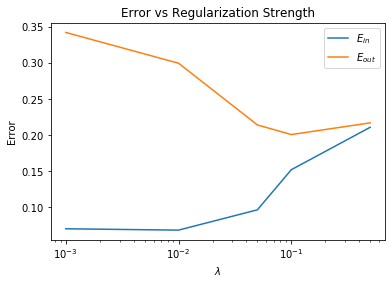

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(regs, E_ins, label='$E_{in}$')
plt.plot(regs, E_outs, label='$E_{out}$')
plt.title('Error vs Regularization Strength')
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.legend()
ax.set_xscale('log')

We see that the best regularization strength is 0.1. Now, we will check for overfitting by plotting $E_\text{in}$ and $E_\text{out}$ over time for $\lambda=0.1$.

In [8]:
U, V, A, B, eins, evals = train_model(M, N, K, Y_train, Y_test, eta, 0.1)

(reg=0.1, K=20) Epoch 83 finished.


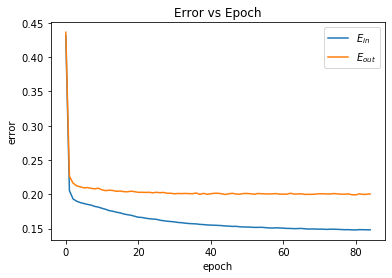

In [10]:
T = len(eins)
plt.figure()
plt.plot(range(T), eins, label='$E_{in}$')
plt.plot(range(T), evals, label='$E_{out}$')
plt.title('Error vs Epoch')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()

This encouraging, as it indicates that there isn't a point where Eout starts decreasing (i.e., the final epoch is essentially the best). Finally, decompose the full dataset:

In [6]:
U, V, A, B, eins, evals = train_model(M, N, K, Y_all, Y_all, eta, 0.1)

(reg=0.1, K=20) Epoch 54 finished.


And now save the final 2 components to a file so that we can visualize it in R.

In [11]:
import pandas as pd

movie_data = pd.read_csv('data/movies.txt', sep='\t',
                         names=['title', 'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary',
                                  'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller',
                                  'war', 'wester'])

svdA, svdS, svdB = np.linalg.svd(V.transpose())
U2 = svdA[:,:2].transpose() @ U.transpose()
V2 = svdA[:,:2].transpose() @ V.transpose()

vis_df = pd.DataFrame({
    'id' : range(1, V2.shape[1]+1),
    'x1' : V2[0,:],
    'x2' : V2[1,:]
})

vis_df.to_csv('movies-2d.csv', index=False)

# Factorization Method 1
Adapted from Homework 5 problem 2.
Implements
$$\text{arg min}_{U,V}\frac\lambda2\left(||U||^2+||V||^2\right)-\frac1{2N}\sum_{(i,j)\in S}\big(Y_{ij}-(U_i\cdot V_i)\big)^2$$
The process (i.e., finding the optimal $\lambda$ and checking for overfitting) is the same as for method 2, so I've ommitted the comments.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sys import stdout

def point_loss(Yij, Ui, Vj):
    return (Yij-np.dot(Ui,Vj))

def grad_U(Yij, Ui, Vj, reg):
    return reg*Ui-point_loss(Yij,Ui,Vj)*Vj

def grad_V(Yij, Ui, Vj, reg):
    return reg*Vj-point_loss(Yij,Ui,Vj)*Ui

def get_err(U, V, Y, reg=0.0):
    n2 = lambda X: np.linalg.norm(X)**2.0
    err = reg*(n2(U)+n2(V))
    for (i, j, Yij) in Y:
        err += point_loss(Yij, U[i-1,:], V[j-1,:])**2.0
    return err/2.0/np.size(Y,0)

def train_model(M, N, K, Y, Yval, eta, reg, eps=0.0001, max_epochs=300):
    U = np.random.rand(M,K)-0.5
    V = np.random.rand(N,K)-0.5
    
    last_loss = get_err(U, V, Y, reg)
    e1diff = None
    
    eins = []
    evals = []
    eins.append(get_err(U, V, Y))
    evals.append(get_err(U, V, Yval))
    
    for e in range(max_epochs):
        for k in np.random.permutation(np.size(Y,0)):
            i, j, Yij = Y[k,:]
            i -= 1
            j -= 1
            U[i,:] -= eta*grad_U(Yij, U[i,:], V[j,:], reg)
            V[j,:] -= eta*grad_V(Yij, U[i,:], V[j,:], reg)
            
        eins.append(get_err(U, V, Y))
        evals.append(get_err(U, V, Yval))
            
        loss = get_err(U, V, Y, reg)
        diff = np.abs(loss-last_loss)
        if e == 0:
            e1diff = diff
        elif diff < eps*e1diff:
            break
        last_loss = loss
        
        stdout.write(f'\r(reg={reg}, K={K}) Epoch {e+1} finished.')
        
    stdout.write('\n')
    return U, V, eins, evals

(reg=0.001, K=20) Epoch 32 finished.
(reg=0.01, K=20) Epoch 23 finished.
(reg=0.05, K=20) Epoch 22 finished.
(reg=0.1, K=20) Epoch 19 finished.
(reg=0.5, K=20) Epoch 9 finished.


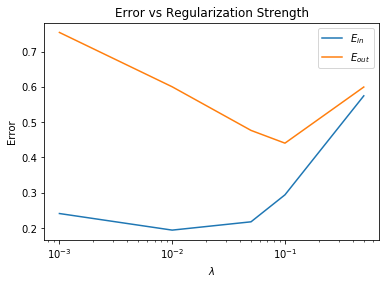

In [11]:
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)
Y_all = np.loadtxt('./data/data.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
K = 20
eta = 0.03 # learning rate

regs = [1e-3, 1e-2, 5e-2, 1e-1, 5e-1]

E_ins = []
E_outs = []

# Use to compute Ein and Eout
for reg in regs:
    U, V, eins, evals = train_model(M, N, K, Y_train, Y_test, eta, reg)
    E_ins.append(eins[-1])
    E_outs.append(evals[-1])
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(regs, E_ins, label='$E_{in}$')
plt.plot(regs, E_outs, label='$E_{out}$')
plt.title('Error vs Regularization Strength')
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.legend()
ax.set_xscale('log')

(reg=0.1, K=20) Epoch 21 finished.


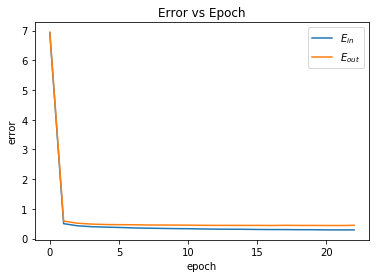

In [13]:
U, V, eins, evals = train_model(M, N, K, Y_train, Y_test, eta, 0.1)
T = len(eins)
plt.figure()
plt.plot(range(T), eins, label='$E_{in}$')
plt.plot(range(T), evals, label='$E_{out}$')
plt.title('Error vs Epoch')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()

In [14]:
U, V, eins, evals = train_model(M, N, K, Y_all, Y_all, eta, 0.1)

(reg=0.1, K=20) Epoch 14 finished.


In [16]:
import pandas as pd


movie_data = pd.read_csv('data/movies.txt', sep='\t',
                         names=['title', 'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary',
                                  'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller',
                                  'war', 'wester'])

svdA, svdS, svdB = np.linalg.svd(V.transpose())
U2 = svdA[:,:2].transpose() @ U.transpose()
V2 = svdA[:,:2].transpose() @ V.transpose()

vis_df = pd.DataFrame({
    'id' : range(1, V2.shape[1]+1),
    'x1' : V2[0,:],
    'x2' : V2[1,:]
})

vis_df.to_csv('method1.csv', index=False)